In [92]:
import numpy as np
import pandas as pd
import nilearn as nil
import seaborn as sns
import nibabel as nib
from scipy import io as sio
import statsmodels.api as sm
from scipy import stats as sst
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import matplotlib.gridspec as gridspec
from statsmodels.sandbox.stats import multicomp as smi

/home/surchs/Venv/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline

In [90]:
in_model = '/data1/guilimin/simons_vip/pheno/dataset_good_exist2.csv'
weights_path = '/data1/guilimin/simons_vip/subtypes_dup_no_age2_fdr/subtype_weights.mat'
subtypes_temp = '/data1/guilimin/simons_vip/subtypes_dup_no_age2_fdr/network_{0}/network_{0}_subtype.mat'
sbt_map_temp= '/data1/guilimin/simons_vip/subtypes_dup_no_age2_fdr/network_{}/mean_subtype.nii.gz'

In [4]:
model = pd.read_csv(in_model, sep=';')

In [5]:
model.head()

,Unnamed: 0,frames_scrubbed,frames_OK,FD,FD_scrubbed,session,sex,family,age_months,age_years,genetic_status,g1,g2,g3
0,s14702xx3xFCAP1_session1_rest,39,79,0.305145,0.227978,1,1,14702,95,7.916667,1,1,0,0
1,s14714xx18xFCAP1_session1_rest,8,110,0.129200,0.118603,1,1,14714,249,20.750000,1,1,0,0
2,s14723xx17xFCAP1_session1_rest,51,67,0.241232,0.139836,1,1,14723,60,5.000000,3,0,0,1
3,s14725xx48xFCAP1_session1_rest,35,83,0.342359,0.249759,1,1,14725,415,34.583333,3,0,0,1
4,s14729xx5xFCAP1_session1_rest,35,83,0.228533,0.158575,1,1,14729,99,8.250000,1,1,0,0


In [6]:
weight_mat = sio.loadmat(weights_path)

In [7]:
weights = weight_mat['weight_mat']

In [8]:
n1 = weights[:, :, 0]

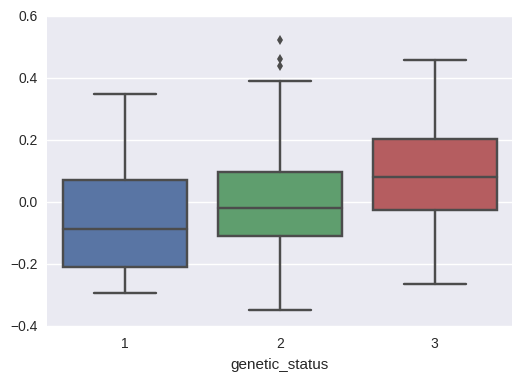

In [9]:
sns.boxplot(model.genetic_status, weights[:, 2, 2])

In [78]:
p_mat = np.zeros((5, 7))
res_list = list()
for nid in range(7):
    tmp_list = list()
    for sid in range(5):
        m = sm.OLS(weights[:, sid, nid], model[['g1','g2','g3']])
        res = m.fit()
        p_mat[sid, nid] = res.f_pvalue
        tmp_list.append(res)
    res_list.append(tmp_list)

In [11]:
pcorr_vec = smi.multipletests(p_mat.flatten(), alpha=0.05, method='fdr_bh')

In [12]:
pcorr_mat = np.reshape(pcorr_vec[0], (5, 7))

In [13]:
hits = np.argwhere(pcorr_mat)
n_hits = len(hits)

In [50]:
hits

array([[0, 5],
       [1, 6],
       [3, 1],
       [4, 6]])

In [53]:
hits[0,1]

5

In [54]:
weights.shape

(124, 5, 7)

In [66]:
model.head()

,Unnamed: 0,frames_scrubbed,frames_OK,FD,FD_scrubbed,session,sex,family,age_months,age_years,genetic_status,g1,g2,g3
0,s14702xx3xFCAP1_session1_rest,39,79,0.305145,0.227978,1,1,14702,95,7.916667,1,1,0,0
1,s14714xx18xFCAP1_session1_rest,8,110,0.129200,0.118603,1,1,14714,249,20.750000,1,1,0,0
2,s14723xx17xFCAP1_session1_rest,51,67,0.241232,0.139836,1,1,14723,60,5.000000,3,0,0,1
3,s14725xx48xFCAP1_session1_rest,35,83,0.342359,0.249759,1,1,14725,415,34.583333,3,0,0,1
4,s14729xx5xFCAP1_session1_rest,35,83,0.228533,0.158575,1,1,14729,99,8.250000,1,1,0,0


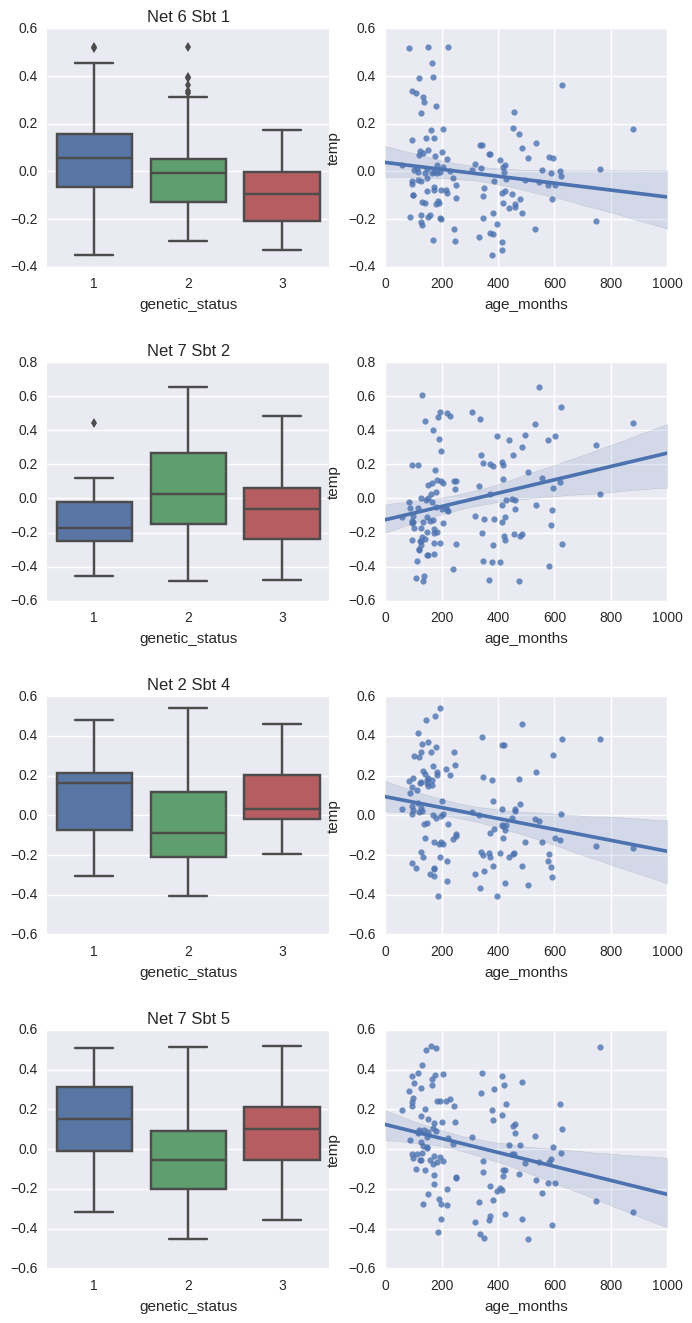

In [76]:
fig = plt.figure(figsize=(8,16))
gs = gridspec.GridSpec(n_hits, 2, hspace=0.4)
for h in range(4):
    net_hit = hits[h,1]
    sbt_hit = hits[h,0]
    ax = fig.add_subplot(gs[h,0])
    sns.boxplot(model.genetic_status, weights[:, sbt_hit, net_hit], ax=ax)
    ax.set_title('Net {} Sbt {}'.format(net_hit+1, sbt_hit+1))
    ax2 = fig.add_subplot(gs[h,1])
    model['temp'] = weights[:, sbt_hit, net_hit]
    sns.regplot(y='temp', x='age_months', data=model, ax=ax2)

In [79]:
hits

array([[0, 5],
       [1, 6],
       [3, 1],
       [4, 6]])

In [77]:
model.shape

(124, 15)

## Look at these subtypes

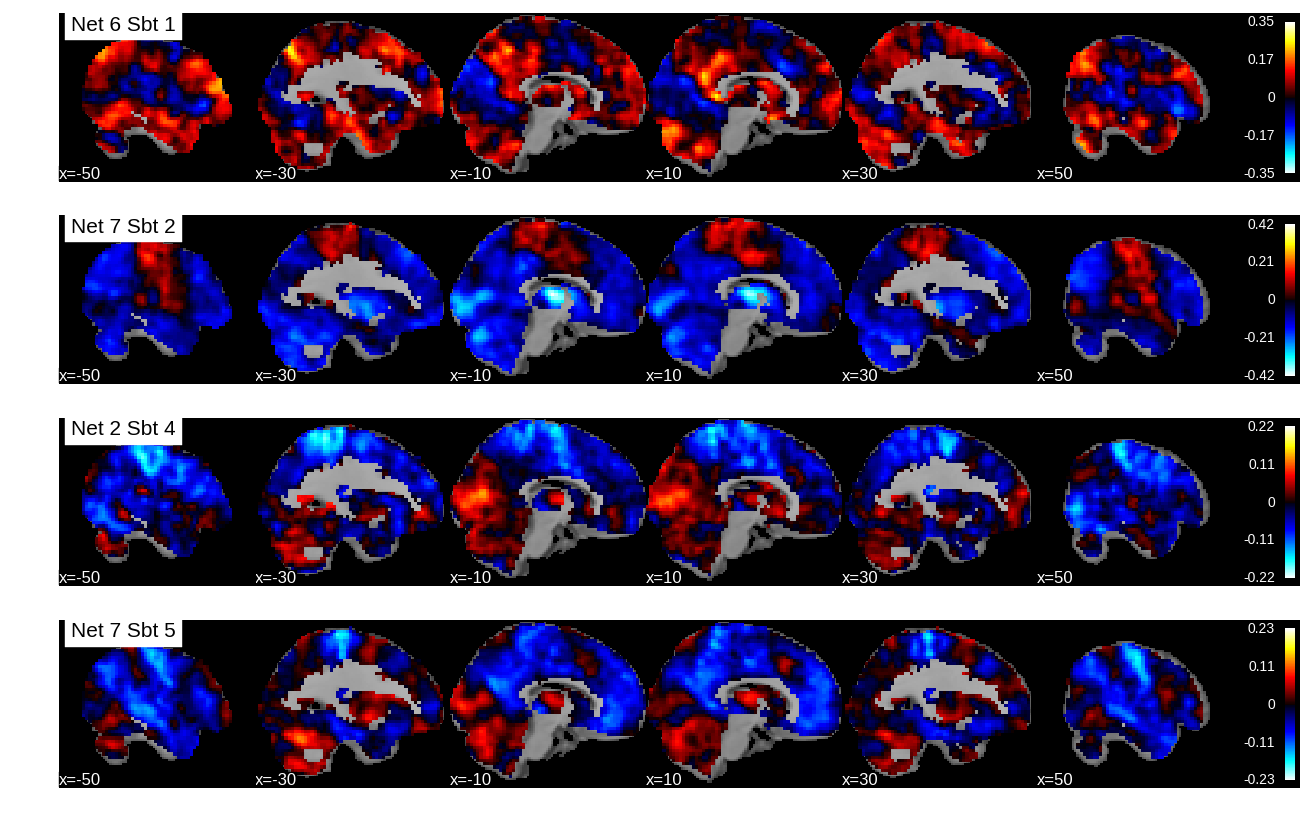

In [99]:
fig = plt.figure(figsize=(16,10))
gs = gridspec.GridSpec(n_hits, 1)
for h in range(4):
    net_hit = hits[h,1]
    sbt_hit = hits[h,0]
    ax = fig.add_subplot(gs[h,0])
    tmp_i = nib.load(sbt_map_temp.format(net_hit+1))
    # Load the corresponding network
    nlp.plot_stat_map(nil.image.index_img(tmp_i, sbt_hit), display_mode='x', threshold=0, 
                      cut_coords=[-50, -30, -10, 10, 30, 50], black_bg=True,axes=ax,
                      title='Net {} Sbt {}'.format(net_hit+1, sbt_hit+1))

In [100]:
model.head()

,Unnamed: 0,frames_scrubbed,frames_OK,FD,FD_scrubbed,session,sex,family,age_months,age_years,genetic_status,g1,g2,g3,temp
0,s14702xx3xFCAP1_session1_rest,39,79,0.305145,0.227978,1,1,14702,95,7.916667,1,1,0,0,0.238247
1,s14714xx18xFCAP1_session1_rest,8,110,0.129200,0.118603,1,1,14714,249,20.750000,1,1,0,0,-0.139016
2,s14723xx17xFCAP1_session1_rest,51,67,0.241232,0.139836,1,1,14723,60,5.000000,3,0,0,1,0.196343
3,s14725xx48xFCAP1_session1_rest,35,83,0.342359,0.249759,1,1,14725,415,34.583333,3,0,0,1,-0.204189
4,s14729xx5xFCAP1_session1_rest,35,83,0.228533,0.158575,1,1,14729,99,8.250000,1,1,0,0,0.256791
